In [40]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

In [41]:
def histogram_logpdf(data, samples, bins=10, handle_zero="add_epsilon"):
    """Computes logpdf using histogram."""

    hist, bin_edges = np.histogram(samples, bins=bins, density=True)

    logpdfs = []
    for x in data:
        bin_idx = np.searchsorted(bin_edges, x) - 1
        if 0 <= bin_idx < len(hist):
            density = hist[bin_idx]
        else:
            density = 0  # Outside bin range

        if density == 0:
            if handle_zero == "add_epsilon":
                density = 1e-10  # Small epsilon value
            elif handle_zero == "nearest_neighbor":
                if bin_idx < 0:
                    density = hist[0]
                elif bin_idx >= len(hist):
                    density = hist[-1]
            elif handle_zero == "min_value":  # use minimum density from hist
                density = (
                    np.min(hist[hist > 0]) if np.any(hist > 0) else 1e-10
                )  # min hist value or espilon if empty hist
            # Add other handling methods as needed (e.g. kernel density estimation)

        logpdfs.append(np.log(density))
    return np.array(logpdfs)


def ecdf_logpdf(data, samples):
    """Computes logpdf using ECDF."""
    quantiles = samples
    probabilities = np.arange(1, len(samples) + 1) / len(samples)
    logpdfs = []

    for x in data:
        idx = np.searchsorted(quantiles, x)

        if 0 < idx < len(quantiles):
            p2 = probabilities[idx]
            p1 = probabilities[idx - 1]
            q2 = quantiles[idx]
            q1 = quantiles[idx - 1]
            pdf = (p2 - p1) / (q2 - q1)
        elif idx == 0:  # extrapolate left using first two points (or similar)
            p2 = probabilities[1]
            p1 = probabilities[0]
            q2 = quantiles[1]
            q1 = quantiles[0]
            pdf = (p2 - p1) / (q2 - q1)
        elif idx == len(quantiles):  # extrapolate right using last two points
            p2 = probabilities[-1]
            p1 = probabilities[-2]
            q2 = quantiles[-1]
            q1 = quantiles[-2]
            pdf = (p2 - p1) / (q2 - q1)
        else:  # should not occur but can be handled using e.g. edge values
            pdf = 0

        logpdfs.append(np.log(pdf if pdf > 0 else 1e-10))  # avoid log(0)

    return np.array(logpdfs)

In [ ]:
def ecdf_from_samples(samples):
    sorted_samples = np.sort(samples)
    probs = np.arange(len(samples)) / len(samples)
    def ecdf(x):
        idx = np.searchsorted(sorted_samples, x)
        vals = []
        for i in idx:
            if i < 0:
                vals.append(0.0)
                continue
            if i >= len(probs):
                vals.append(1.0)
                continue
            vals.append(probs[i])
        return np.array(vals)
    return ecdf


def logpdf_ecdf(samples):
    

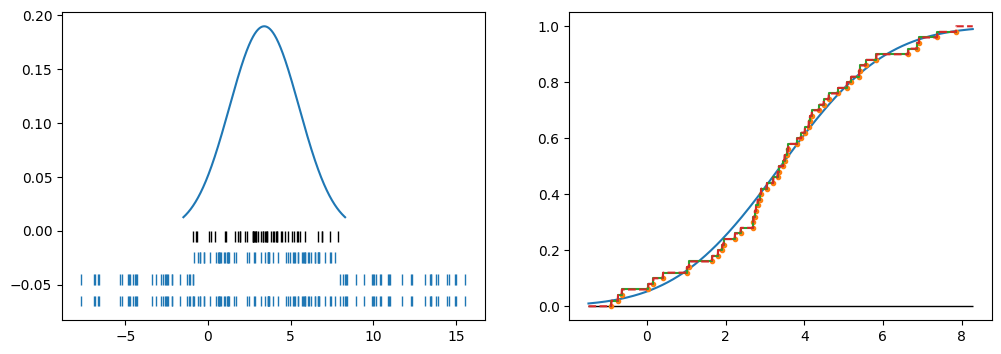

In [93]:
# np.random.seed(938456)

# Parameters for the normal distribution
LOC = 3.4
SCALE = 2.1
N_SAMPLES = 50
N_DATA = 60

distr = stats.norm(loc=LOC, scale=SCALE)

# Draw samples from the normal distribution
samples = distr.rvs(N_SAMPLES)
samples.sort()  # Sort for ECDF calculations

# Create datasets for likelihood computation
max_abs_samples = np.abs(samples).max()
eps = max_abs_samples * 1e-6

data_inside = np.random.uniform(
    samples.min(), samples.max(), N_DATA
)
data_outside = np.concatenate(
    [
        np.random.uniform(
            samples.min() - max_abs_samples, samples.min() - eps, N_DATA // 2
        ),
        np.random.uniform(
            samples.max() + eps, samples.max() + max_abs_samples, N_DATA // 2
        ),
    ]
)
data_normal = np.concatenate((data_inside, data_outside))

x = np.linspace(distr.ppf(0.01), distr.ppf(1 - 0.01), 1000)

DY = -0.01

fig, axs = plt.subplots(ncols=2, figsize=(12, 4))

axs[0].plot(x, distr.pdf(x))
axs[0].vlines(samples, DY * 1, DY * 0, color="k", lw=1.0)
axs[0].vlines(data_inside, DY * 3, DY * 2, lw=1.0)
axs[0].vlines(data_outside, DY * 5, DY * 4, lw=1.0)
axs[0].vlines(data_normal, DY * 7, DY * 6, lw=1.0)

axs[1].plot(x, distr.cdf(x))
axs[1].hlines(0, x.min(), x.max(), lw=1.0, color="k")
axs[1].plot(samples, np.arange(len(samples)) / len(samples), ".")
axs[1].step(samples, np.arange(len(samples)) / len(samples), where="pre")
axs[1].plot(x, ecdf_from_samples(samples)(x), "--")

plt.show()

/var/folders/9k/pz7sq18n26sdjld2rt5h1dr80000gn/T/ipykernel_72498/453906722.py:28: RuntimeWarning: divide by zero encountered in log
  logpdfs.append(np.log(density))


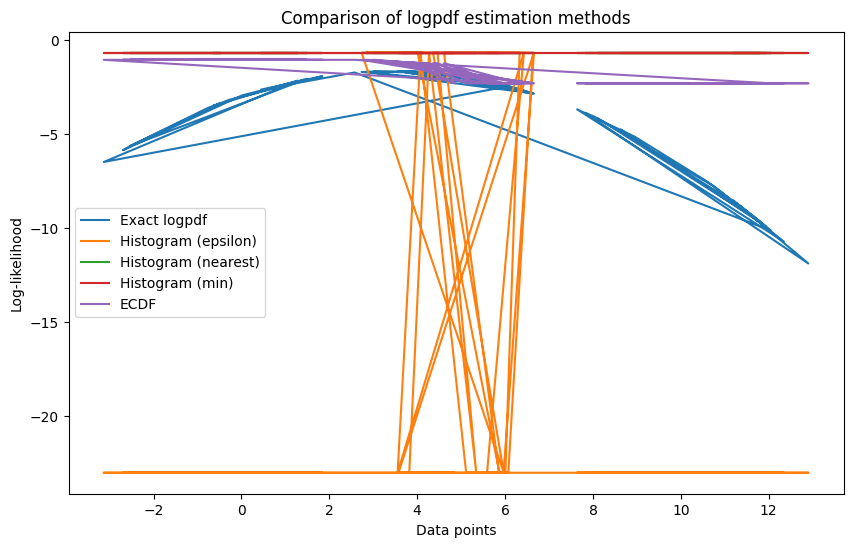

In [44]:
exact_logpdf = distr.logpdf(data_normal)

# Compute likelihoods using different methods

hist_logpdf_epsilon = histogram_logpdf(data_normal, samples, handle_zero="add_epsilon")
hist_logpdf_nearest = histogram_logpdf(
    data_normal, samples, handle_zero="nearest_neighbor"
)
hist_logpdf_minvalue = histogram_logpdf(data_normal, samples, handle_zero="min_value")
ecdf_logpdf_vals = ecdf_logpdf(data_normal, samples)


# ... (Plotting or other analysis can be added here to compare results)

plt.figure(figsize=(10, 6))
plt.plot(data_normal, exact_logpdf, label="Exact logpdf")
plt.plot(data_normal, hist_logpdf_epsilon, label="Histogram (epsilon)")
plt.plot(data_normal, hist_logpdf_nearest, label="Histogram (nearest)")
plt.plot(data_normal, hist_logpdf_minvalue, label="Histogram (min)")
plt.plot(data_normal, ecdf_logpdf_vals, label="ECDF")
plt.legend()
plt.title("Comparison of logpdf estimation methods")
plt.xlabel("Data points")
plt.ylabel("Log-likelihood")
plt.show()